The setup of the Experiment is in our intermediate project report.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

PARENT_SEED_B = 2023
NUM_EXPERIMENTS = 100

def setup_seeds(parent_seed):
    ss = np.random.SeedSequence(parent_seed)
    return ss.generate_state(NUM_EXPERIMENTS)

CHILD_SEEDS = setup_seeds(PARENT_SEED_B)

In [3]:

def generate_sparse_vector(d, s, rng):
    w = np.zeros(d)
    nonzero_indices = rng.choice(d, size=s, replace=False)
    w[nonzero_indices] = 1.0/np.sqrt(s)
    return w

def generate_data(w_star, n, rng):
    d = len(w_star)
    X = rng.normal(0, 1, size=(n, d))
    linear_pred = X @ w_star
    y_relu = np.maximum(0, linear_pred)
    y_lin = linear_pred
    return X, y_relu, y_lin

def hard_threshold(v, s):
    if s >= len(v): return v
    idx = np.abs(v).argsort()[-s:]
    w = np.zeros_like(v)
    w[idx] = v[idx]
    return w

def l1_projection(z, R):
    if np.linalg.norm(z, 1) <= R: return z
    def phi(theta): return np.sum(np.maximum(np.abs(z)-theta, 0)) - R
    theta_max = np.max(np.abs(z))
    theta = bisect(phi, 0, theta_max, xtol=1e-6, maxiter=100)
    return np.sign(z) * np.maximum(np.abs(z)-theta, 0)

def l2_projection(z, R):
    norm_z = np.linalg.norm(z)
    return z if norm_z <= R else (R/norm_z)*z

def gradient_relu(X, w, y):
    n = X.shape[0]
    pred = X@w
    relu_pred = np.maximum(0, pred)
    factor = np.where(pred>0, 2.0, np.where(pred<0, 0.0, 1.0))
    residual = (relu_pred - y) * factor
    return (X.T @ residual)/n

def gradient_linear(X, w, y):
    n = X.shape[0]
    residual = (X@w - y)
    return (X.T @ residual)/n

def generic_pgd(X, y, projection_fn, reg_param, max_iter=50, model="relu"):
    n, d = X.shape
    w = np.zeros(d)
    history = [w.copy()]
    for t in range(max_iter):
        grad = gradient_relu(X, w, y) if model=="relu" else gradient_linear(X, w, y)
        step_size = 2.0 if t==0 else 1.0
        w_tmp = w - step_size*grad
        w = projection_fn(w_tmp, reg_param)
        history.append(w.copy())
    return history

def generic_gd(X, y, reg_type, lambda_, max_iter=50, model="relu"):
    n, d = X.shape
    w = np.zeros(d)
    history = [w.copy()]
    reg_loss_history = []
    original_loss_history = []

    for t in range(max_iter):
        if model == 'relu':
            grad = gradient_relu(X, w, y)
        else:
            grad = gradient_linear(X, w, y)

        if reg_type == 'l2':
            grad += 2 * lambda_ * w
        elif reg_type == 'l1':
            grad += lambda_ * np.sign(w)  #


        step_size = 2.0 if t == 0 else 1.0
        w = w - step_size * grad
        history.append(w.copy())

        if model == 'relu':
            original_loss = loss_relu(X, w, y)
        else:
            original_loss = np.mean((X @ w - y) ** 2)

        reg_term = lambda_ * (np.linalg.norm(w, 1) if reg_type == 'l1' else np.linalg.norm(w)**2)
        reg_loss_history.append(original_loss + reg_term)
        original_loss_history.append(original_loss)

    return history, reg_loss_history, original_loss_history

def loss_relu(X, w, y):
    return np.mean((np.maximum(0, X@w) - y)**2)

def aggregate_results(all_results):
    aggregated = {'errors': {}, 'losses': {}, 'compliance': {'l1': [], 'l2': []}}

    for key in all_results[0]['errors']:
        aggregated['errors'][key] = np.mean([r['errors'][key] for r in all_results], axis=0)

    for key in all_results[0]['losses']:
        if '_gd' in key:
            aggregated['losses'][key] = {
                'regularized': np.mean([r['losses'][key]['regularized'] for r in all_results], axis=0),
                'original': np.mean([r['losses'][key]['original'] for r in all_results], axis=0)
            }
        else:
            aggregated['losses'][key] = np.mean([r['losses'][key] for r in all_results], axis=0)

    for reg in ['l1', 'l2']:
        target = all_results[0]['norms'][reg]['target']
        compliant = [r['norms'][reg]['actual'] <= target for r in all_results]
        aggregated['compliance'][reg] = np.mean(compliant) * 100

    return aggregated

def run_single_experiment(child_seed):
    rng = np.random.default_rng(child_seed)
    d, s = 1000, 20
    n = int(8*s*np.log(d/s))
    w_star = generate_sparse_vector(d, s, rng)
    X, y_relu, y_lin = generate_data(w_star, n, rng)

    metrics = {'errors': {}, 'losses': {}, 'norms': {}}
    configs = {
        'l0': (lambda z, _: hard_threshold(z, s), 0),
        'l1': (l1_projection, np.linalg.norm(w_star, 1)),
        'l2': (l2_projection, 1.0)
    }
    gd_lambda = {'l1': 0.1, 'l2': 0.5}  # Regularization strengths

    for reg in ['l0', 'l1', 'l2']:
        for model in ['relu', 'linear']:
            proj_fn, R = configs[reg]
            hist = generic_pgd(X, y_relu if model=='relu' else y_lin,
                             proj_fn, R, model=model)
            metrics['errors'][(reg, model)] = [np.linalg.norm(w-w_star) for w in hist]
            if model == 'relu':
                metrics['losses'][reg] = [loss_relu(X, w, y_relu) for w in hist]

    for reg in ['l1', 'l2']:
        # For ReLU model
        hist_gd, reg_loss, orig_loss = generic_gd(X, y_relu, reg, gd_lambda[reg], model='relu')
        metrics['errors'][(f'{reg}_gd', 'relu')] = [np.linalg.norm(w-w_star) for w in hist_gd]
        metrics['losses'][f'{reg}_gd'] = {
            'regularized': reg_loss,
            'original': orig_loss
        }
        final_w = hist_gd[-1]
        metrics['norms'][reg] = {
            'actual': np.linalg.norm(final_w, 1) if reg == 'l1' else np.linalg.norm(final_w),
            'target': configs[reg][1]
        }

    return metrics

def run_l2_scaling_experiment(n_scale=1, seed=CHILD_SEEDS[0]):
    rng = np.random.default_rng(seed)
    d, s = 1000, 20
    base_n = int(8*s*np.log(d/s))
    n = base_n * n_scale

    w_star = generate_sparse_vector(d, s, rng)
    X, _, y_lin = generate_data(w_star, n, rng)

    hist = generic_pgd(X, y_lin, l2_projection, 1.0, model='linear')
    return [np.linalg.norm(w-w_star) for w in hist]

In [4]:
all_results = []
for exp_num, seed in enumerate(CHILD_SEEDS, 1):
    result = run_single_experiment(seed)
    all_results.append(result)
    print(f"\rCompleted {exp_num}/{NUM_EXPERIMENTS}", end="", flush=True)

aggregated = aggregate_results(all_results)
l2_scaling_results = {
    'n1': run_l2_scaling_experiment(1),
    'n10': run_l2_scaling_experiment(10),
    'n100': run_l2_scaling_experiment(100)
}

Completed 100/100

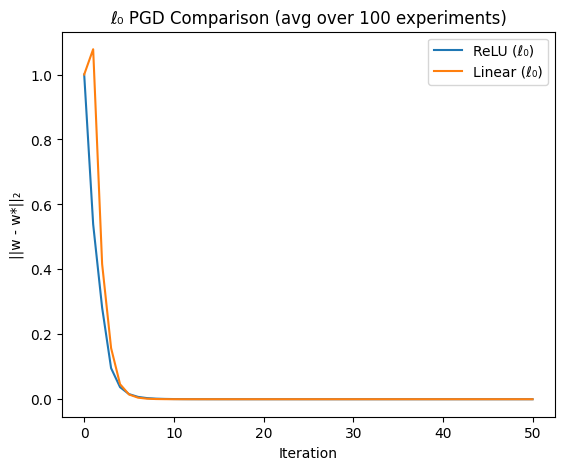

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(aggregated['errors'][('l0', 'relu')], label='ReLU (ℓ₀)')
plt.plot(aggregated['errors'][('l0', 'linear')], label='Linear (ℓ₀)')
plt.title('ℓ₀ PGD Comparison (avg over 100 experiments)')
plt.xlabel('Iteration')
plt.ylabel('||w - w*||₂')
plt.legend()
plt.show()

The plot is the result over 100 experiments.

From the plot, both the ReLU (ℓ₀) and Linear (ℓ₀) methods start with relatively high values and then quickly drop towards zero within the first 10 iterations. After this rapid descent, both curves remain close to zero, indicating successful minimization of the objective. Overall, there appears to be minimal difference in their final performance, suggesting both methods are effective for this ℓ₀-based PGD task.

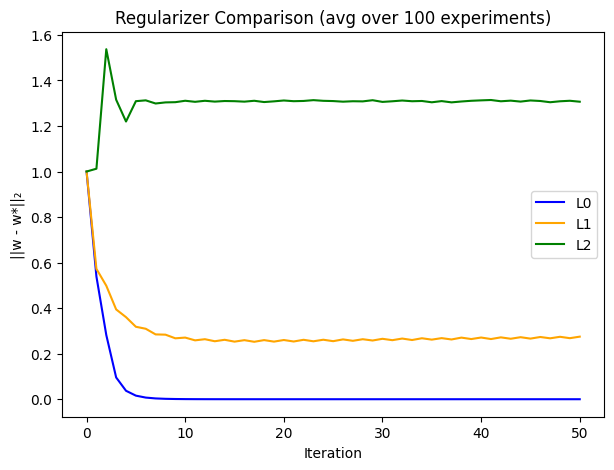

In [13]:
plt.figure(figsize=(7, 5))
styles = {'l0': ('blue', '-'), 'l1': ('orange', '-'), 'l2': ('green', '-')}
for (reg, model), err in aggregated['errors'].items():
    if model == 'relu' and reg in styles:  # Check if reg is in styles
        plt.plot(err, color=styles[reg][0], linestyle=styles[reg][1],
                label=f'{reg.upper()}')
plt.title('Regularizer Comparison (avg over 100 experiments)')
plt.xlabel('Iteration')
plt.ylabel('||w - w*||₂')
plt.legend()
plt.show()

From the figure, the L0 curve rapidly drops to near zero within the first few iterations, indicating a strong push towards sparsity or minimization. The L1 curve also decreases but settles at a higher plateau, while the L2 curve remains relatively large and stable throughout the iterations.

Appearently, both L1 and L2 constraints doesn't converge to the global Optimum. Therefore, We next plotted the loss vs. iteration graph to check if it actually converge.

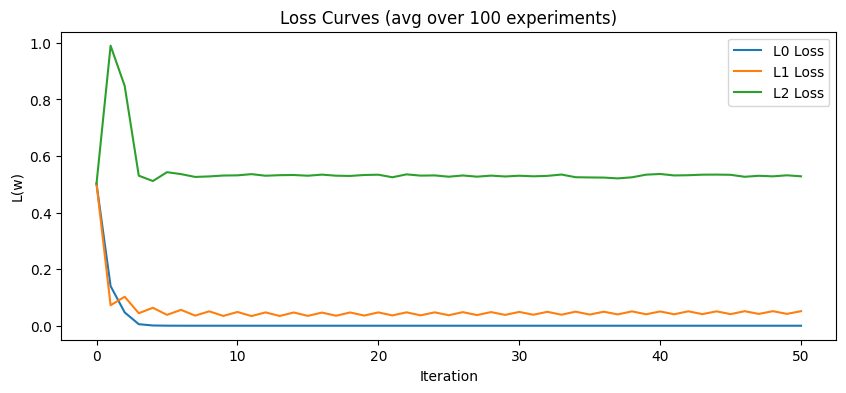

In [16]:
plt.figure(figsize=(10, 4))
for reg in ['l0', 'l1', 'l2']:
    plt.plot(aggregated['losses'][reg], label=f'{reg.upper()} Loss')
plt.title('Loss Curves (avg over 100 experiments)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('L(w)')
plt.show()

From the figure, the L0 loss quickly drops and stays near zero after only a few iterations, indicating rapid convergence. The L1 loss also shows a quick descent but stabilizes at a slightly higher value, while the L2 loss remains at the highest level among the three.

This indicates that with L1 and L2 constraints, the PGD doesn't converge well. We doubt this is because L1 and L2 constraints will lead to a larger gaussian width, so larger $n_0$ (minimal number of samples) is needed.

So we ran the experiments with larger n for L2 norm to check the convergence:

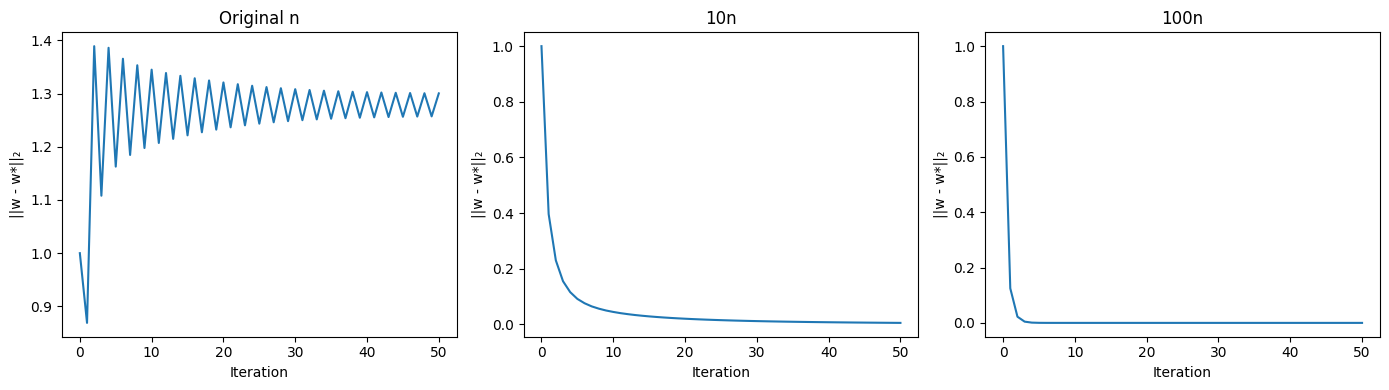

In [18]:
plt.figure(figsize=(14, 4))
titles = ['Original n', '10n', '100n']
for i, (key, title) in enumerate(zip(['n1', 'n10', 'n100'], titles)):
    plt.subplot(1, 3, i+1)
    #plt.plot(l1_scaling_results[key])
    plt.plot(l2_scaling_results[key])
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('||w - w*||₂')
plt.tight_layout()
plt.show()

In the “Original n” plot, the norm ∥𝑤−𝑤∗∥ oscillates between about 0.9 and 1.4, suggesting some instability or difficulty in converging. By contrast, both the “10xn” and “100xn” plots show a rapid and steady decrease in  ∥𝑤−𝑤∗∥ over the iterations, indicating more stable convergence. This implies that increasing the smaple size lead to smoother, more efficient convergence behavior.

This also indicates that the assumption on the closed set and the minimal number of samples defined as the squared Gaussian Width is very critical to the convergence as the theoretical approach. Essentially, this Gaussian Width guaranteed that $\langle x_i, w \rangle$ is bounded by hyper probability since samples are concentrate enough.

In the following experiments, we will use n = 100 n' where n' denote the original setup for L0 constraints.

In [5]:

def regularized_gd_experiment(X, y, w_star, reg_type='l1', lambda_reg=0.01, max_iter=50, step_size=1.0, model='relu'):

    w = np.zeros(X.shape[1])

    if model == 'relu':
        init_loss = loss_relu(X, w, y)
    else:
        init_loss = np.mean((X @ w - y)**2)
    orig_loss_hist = [init_loss]
    reg_loss_hist = [init_loss]

    for t in range(max_iter):
        if model == 'relu':
            orig_loss = loss_relu(X, w, y)
            grad_orig = gradient_relu(X, w, y)
        else:
            orig_loss = np.mean((X @ w - y)**2)
            grad_orig = gradient_linear(X, w, y)

        if reg_type == 'l1':
            reg_loss = lambda_reg * np.linalg.norm(w, 1)
            reg_grad = lambda_reg * np.sign(w)
        elif reg_type == 'l2':
            reg_loss = lambda_reg * np.linalg.norm(w, 2)**2
            reg_grad = 2 * lambda_reg * w
        else:
            reg_loss = 0
            reg_grad = np.zeros_like(w)

        total_loss = orig_loss + reg_loss

        orig_loss_hist.append(orig_loss)
        reg_loss_hist.append(total_loss)
        total_grad = grad_orig + reg_grad
        w = w - step_size * total_grad

    return w, orig_loss_hist, reg_loss_hist


def grid_search_gd_parameters(child_seed,
                              reg_types=['l1', 'l2'],
                              lambda_values=[0.001, 0.01, 0.1, 1.0],
                              step_sizes=[0.1, 0.01, 0.001],
                              max_iter=50,
                              model='relu'):

    rng = np.random.default_rng(child_seed)
    d, s = 1000, 20
    n = int(8 * s * np.log(d / s))
    w_star = generate_sparse_vector(d, s, rng)

    X, y_relu, y_lin = generate_data(w_star, n, rng)
    y = y_relu if model == 'relu' else y_lin

    results = []
    for reg_type in reg_types:
        for lambda_reg in lambda_values:
            for step_size in step_sizes:
                w_final, orig_loss_hist, reg_loss_hist = regularized_gd_experiment(
                    X, y, w_star,
                    reg_type=reg_type,
                    lambda_reg=lambda_reg,
                    max_iter=max_iter,
                    step_size=step_size,
                    model=model
                )

                final_loss = reg_loss_hist[-1]
                exploded = (final_loss > 1e10)

                final_norm = np.linalg.norm(w_final, 2) if reg_type == 'l2' else np.linalg.norm(w_final, 1)

                results.append({
                    'reg_type': reg_type,
                    'lambda_reg': lambda_reg,
                    'step_size': step_size,
                    'final_loss': final_loss,
                    'final_norm': final_norm,
                    'exploded': exploded,
                    'orig_loss_hist': orig_loss_hist,
                    'reg_loss_hist': reg_loss_hist
                })

    return results


def find_best_parameters(results, sort_key='final_loss'):

    stable_runs = [r for r in results if not r['exploded']]
    if not stable_runs:
        print("No stable runs found! All exploded. Try smaller step sizes or bigger lambda_reg.")
        return None

    stable_runs.sort(key=lambda r: r[sort_key])

    return stable_runs[0]

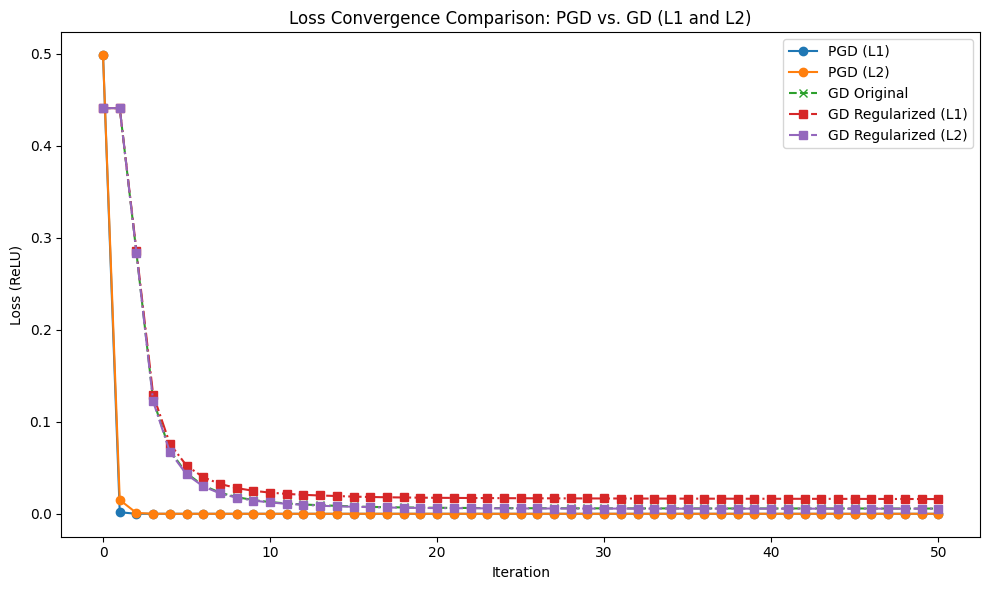

In [11]:

seed = CHILD_SEEDS[0]
rng = np.random.default_rng(seed)
d, s = 1000, 20
n = 100 * int(8 * s * np.log(d/s))
w_star = generate_sparse_vector(d, s, rng)
X, y_relu, y_lin = generate_data(w_star, n, rng)
y = y_relu
max_iter = 50

R_l1 = np.linalg.norm(w_star, 1)
history_pgd_l1 = generic_pgd(X, y, l1_projection, R_l1, max_iter=max_iter, model='relu')
loss_pgd_l1 = [loss_relu(X, w, y) for w in history_pgd_l1]

R_l2 = 1.0
history_pgd_l2 = generic_pgd(X, y, l2_projection, R_l2, max_iter=max_iter, model='relu')
loss_pgd_l2 = [loss_relu(X, w, y) for w in history_pgd_l2]

grid_results_l1 = grid_search_gd_parameters(
    seed,
    reg_types=['l1'],
    lambda_values=[0.001, 0.01, 0.1, 1.0],
    step_sizes=[0.1, 0.01, 0.001],
    max_iter=max_iter,
    model='relu'
)
best_run_l1 = find_best_parameters(grid_results_l1, sort_key='final_loss')

grid_results_l2 = grid_search_gd_parameters(
    seed,
    reg_types=['l2'],
    lambda_values=[0.001, 0.01, 0.1, 1.0],
    step_sizes=[0.1, 0.01, 0.001],
    max_iter=max_iter,
    model='relu'
)
best_run_l2 = find_best_parameters(grid_results_l2, sort_key='final_loss')

plt.figure(figsize=(10, 6))
iterations = range(max_iter + 1)

plt.plot(iterations, loss_pgd_l1, label='PGD (L1)', linestyle='-', marker='o')
plt.plot(iterations, loss_pgd_l2, label='PGD (L2)', linestyle='-', marker='o')

if best_run_l1 is not None:
    # plt.plot(iterations, best_run_l1['orig_loss_hist'], label='GD Original', linestyle='--', marker='x')
    plt.plot(iterations, best_run_l1['reg_loss_hist'], label='GD Regularized (L1)', linestyle='-.', marker='s')
else:
    print("No stable GD run found for L1 regularization.")

if best_run_l2 is not None:
    # plt.plot(iterations, best_run_l2['orig_loss_hist'], label='GD Original (L2)', linestyle='--', marker='x')
    plt.plot(iterations, best_run_l2['reg_loss_hist'], label='GD Regularized (L2)', linestyle='-.', marker='s')
else:
    print("No stable GD run found for L2 regularization.")

plt.title("Loss Convergence Comparison: PGD vs. GD (L1 and L2)")
plt.xlabel("Iteration")
plt.ylabel("Loss (ReLU) with Reg")
plt.legend()
plt.tight_layout()
plt.show()

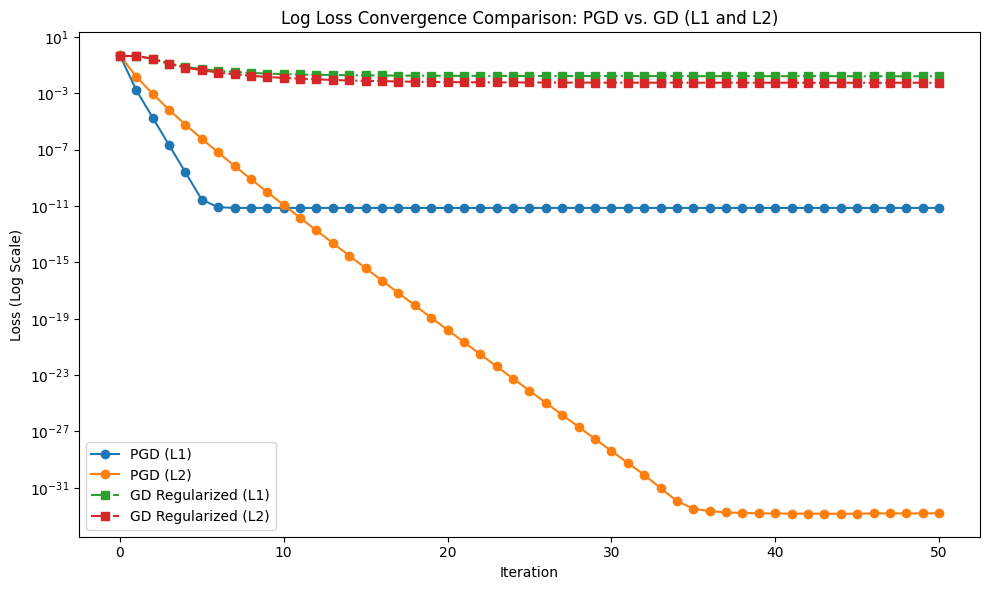

In [19]:
plt.figure(figsize=(10, 6))
iterations = range(max_iter + 1)

plt.plot(iterations, loss_pgd_l1, label='PGD (L1)', linestyle='-', marker='o')
plt.plot(iterations, loss_pgd_l2, label='PGD (L2)', linestyle='-', marker='o')

if best_run_l1 is not None:
    plt.plot(iterations, best_run_l1['reg_loss_hist'], label='GD Regularized (L1)', linestyle='-.', marker='s')
else:
    print("No stable GD run found for L1 regularization.")

if best_run_l2 is not None:
    plt.plot(iterations, best_run_l2['reg_loss_hist'], label='GD Regularized (L2)', linestyle='-.', marker='s')
else:
    print("No stable GD run found for L2 regularization.")

# Set the y-axis to a logarithmic scale
plt.yscale('log')

plt.title("Log Loss Convergence Comparison: PGD vs. GD (L1 and L2)")
plt.xlabel("Iteration")
plt.ylabel("Loss (Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()


According to the graph, all methods  converge to relatively lower losses. PGD converges faster than GD with both L1 and L2 constraints. Note, for this graph, the loss is the orignal loss + regularization for Gradients, and we applied a grid search to find the best coefficient for the regularization term.

However, this regularization term will influence the actual loss objective. What's more, we are not sure if these regularization term actually lead to a "hard" feasible solution.

In the follows section, we will try to figure this out.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_norms(reg_type='l1', lambda_reg=0.01, max_iter=50, step_size=1.0, model='relu', num_experiments=100):
    final_norms = []
    for seed in CHILD_SEEDS[:num_experiments]:
        result = run_regularized_gd_experiment(seed, reg_type, lambda_reg, max_iter, step_size, model)
        if reg_type == 'l1':
            norm_val = np.linalg.norm(result['w_final'], 1)
        else:
            norm_val = np.linalg.norm(result['w_final'], 2)
        final_norms.append(norm_val)
    avg_final_norm = np.mean(final_norms)
    var_final_norm = np.var(final_norms)
    return avg_final_norm, var_final_norm

def run_regularized_gd_experiment(child_seed, reg_type='l1', lambda_reg=0.01, max_iter=50, step_size=1.0, model='relu'):
    rng = np.random.default_rng(child_seed)
    d, s = 1000, 20
    n = int(8 * s * np.log(d / s))
    w_star = generate_sparse_vector(d, s, rng)
    X, y_relu, y_lin = generate_data(w_star, n, rng)
    y = y_relu if model == 'relu' else y_lin
    try:
        w_final, orig_loss_hist, reg_loss_hist, w_hist = regularized_gd_experiment(X, y, w_star, reg_type, lambda_reg, max_iter, step_size, model)
    except ValueError:
        w_final, orig_loss_hist, reg_loss_hist = regularized_gd_experiment(X, y, w_star, reg_type, lambda_reg, max_iter, step_size, model)
        w_hist = [w_final] * (max_iter + 1)
    l1_norm = np.linalg.norm(w_final, 1)
    l2_norm = np.linalg.norm(w_final, 2)
    threshold = np.linalg.norm(w_star, 1) * 50 if reg_type == 'l1' else 50
    return {'w_final': w_final, 'w_hist': w_hist, 'orig_loss_hist': orig_loss_hist, 'reg_loss_hist': reg_loss_hist, 'w_star': w_star, 'l1_norm': l1_norm, 'l2_norm': l2_norm, 'threshold': threshold}

lambda_list = [1e-5, 0.0001, 0.001, 0.01, 0.1, 1.0]
num_experiments = 100
max_iter = 50
step_size = 0.1

avg_final_norms_l1 = []
std_final_norms_l1 = []
for lam in lambda_list:
    avg_norm, var_norm = evaluate_norms(reg_type='l1', lambda_reg=lam, max_iter=max_iter, step_size=step_size, model='relu', num_experiments=num_experiments)
    avg_final_norms_l1.append(avg_norm)
    std_final_norms_l1.append(np.sqrt(var_norm))
    print(f"Lambda {lam} (L1): Final average norm = {avg_norm:.4f} with std = {np.sqrt(var_norm):.4f}")

avg_final_norms_l2 = []
std_final_norms_l2 = []
for lam in lambda_list:
    avg_norm, var_norm = evaluate_norms(reg_type='l2', lambda_reg=lam, max_iter=max_iter, step_size=step_size, model='linear', num_experiments=num_experiments)
    avg_final_norms_l2.append(avg_norm)
    std_final_norms_l2.append(np.sqrt(var_norm))
    print(f"Lambda {lam} (L2): Final average norm = {avg_norm:.4f} with std = {np.sqrt(var_norm):.4f}")


Lambda 1e-05 (L1): Final average norm = 12.3208 with std = 0.3105
Lambda 0.0001 (L1): Final average norm = 12.1597 with std = 0.3081
Lambda 0.001 (L1): Final average norm = 10.7470 with std = 0.2738
Lambda 0.01 (L1): Final average norm = 6.0161 with std = 0.0792
Lambda 0.1 (L1): Final average norm = 6.9811 with std = 0.2137
Lambda 1.0 (L1): Final average norm = 51.8016 with std = 1.0977
Lambda 1e-05 (L2): Final average norm = 0.7386 with std = 0.0135
Lambda 0.0001 (L2): Final average norm = 0.7385 with std = 0.0135
Lambda 0.001 (L2): Final average norm = 0.7374 with std = 0.0135
Lambda 0.01 (L2): Final average norm = 0.7265 with std = 0.0133
Lambda 0.1 (L2): Final average norm = 0.6380 with std = 0.0125
Lambda 1.0 (L2): Final average norm = 0.3365 with std = 0.0090


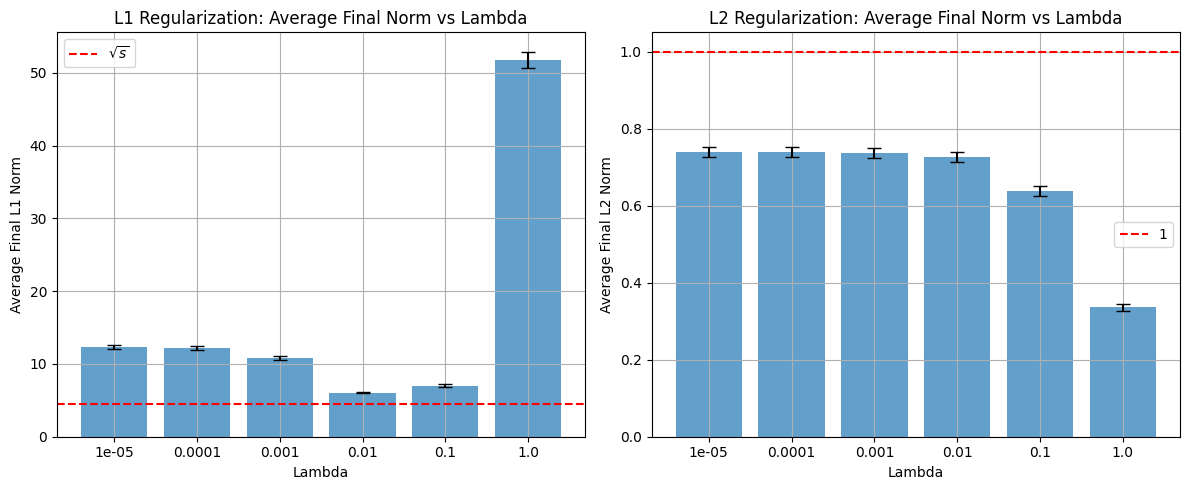

In [38]:
s = 20

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
x_pos = np.arange(len(lambda_list))

ax[0].bar(x_pos, avg_final_norms_l1, yerr=std_final_norms_l1, align='center', alpha=0.7, capsize=5)
ax[0].axhline(np.sqrt(20), color='red', linestyle='--', label=r'$\sqrt{s}$')
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels([str(lam) for lam in lambda_list])
ax[0].set_title("L1 Regularization: Average Final Norm vs Lambda")
ax[0].set_xlabel("Lambda")
ax[0].set_ylabel("Average Final L1 Norm")
ax[0].legend()
ax[0].grid(True)

ax[1].bar(x_pos, avg_final_norms_l2, yerr=std_final_norms_l2, align='center', alpha=0.7, capsize=5)
ax[1].axhline(1, color='red', linestyle='--', label='1')
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels([str(lam) for lam in lambda_list])
ax[1].set_title("L2 Regularization: Average Final Norm vs Lambda")
ax[1].set_xlabel("Lambda")
ax[1].set_ylabel("Average Final L2 Norm")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


We run the experiments for l1 and l2 experiments 100 times respectively, and plot the average l1 norm and l2 norm with std respectively. The red line represent the feasible region. The region bellow the red line indicates a feasible result. As the result, the experiment indicates that regularization works pretty well with l2 norms, guarantee the feasiblity of our constraint optimization task. However, for l1 norms, the regularization can only be regarded as a soft constraint. It gives no guarantee on the feasiblitly.

For L1 norm with lambda 1.0, we think the explosion of l1 norm is because the learning rate doesn't fit.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_loss_hist(reg_type='l1', lambda_reg=0.01, max_iter=50, step_size=1.0, model='relu', num_experiments=100):
    loss_histories = []
    for seed in CHILD_SEEDS[:num_experiments]:
        result = run_regularized_gd_experiment(seed, reg_type, lambda_reg, max_iter, step_size, model)
        loss_histories.append(result['orig_loss_hist'])
    loss_histories = np.stack(loss_histories, axis=0)
    avg_loss_hist = np.mean(loss_histories, axis=0)
    var_loss_hist = np.var(loss_histories, axis=0)
    return avg_loss_hist, var_loss_hist

def run_regularized_gd_experiment(child_seed, reg_type='l1', lambda_reg=0.01, max_iter=50, step_size=1.0, model='relu'):
    rng = np.random.default_rng(child_seed)
    d, s = 1000, 20
    n = int(8 * s * np.log(d / s))
    w_star = generate_sparse_vector(d, s, rng)
    X, y_relu, y_lin = generate_data(w_star, n, rng)
    y = y_relu if model == 'relu' else y_lin
    try:
        w_final, orig_loss_hist, reg_loss_hist, w_hist = regularized_gd_experiment(X, y, w_star, reg_type, lambda_reg, max_iter, step_size, model)
    except ValueError:
        w_final, orig_loss_hist, reg_loss_hist = regularized_gd_experiment(X, y, w_star, reg_type, lambda_reg, max_iter, step_size, model)
        w_hist = [w_final] * (max_iter + 1)
    l1_norm = np.linalg.norm(w_final, 1)
    l2_norm = np.linalg.norm(w_final, 2)
    threshold = np.linalg.norm(w_star, 1) * 50 if reg_type == 'l1' else 50
    return {'w_final': w_final, 'w_hist': w_hist, 'orig_loss_hist': orig_loss_hist, 'reg_loss_hist': reg_loss_hist, 'w_star': w_star, 'l1_norm': l1_norm, 'l2_norm': l2_norm, 'threshold': threshold}

lambda_list = [1e-5, 0.0001, 0.001, 0.01, 0.1, 1.0]
num_experiments = 100
max_iter = 50
step_size = 0.1

l1_results = {}
for lam in lambda_list:
    avg_loss_hist, var_loss_hist = evaluate_loss_hist(reg_type='l1', lambda_reg=lam,
                                                      max_iter=max_iter, step_size=step_size,
                                                      model='relu', num_experiments=num_experiments)
    l1_results[lam] = {'avg': avg_loss_hist, 'var': var_loss_hist}
    print(f"Lambda {lam} (L1): Final original loss = {avg_loss_hist[-1]:.4f}")

l2_results = {}
for lam in lambda_list:
    avg_loss_hist, var_loss_hist = evaluate_loss_hist(reg_type='l2', lambda_reg=lam,
                                                      max_iter=max_iter, step_size=step_size,
                                                      model='linear', num_experiments=num_experiments)
    l2_results[lam] = {'avg': avg_loss_hist, 'var': var_loss_hist}
    print(f"Lambda {lam} (L2): Final original loss = {avg_loss_hist[-1]:.4f}")


Lambda 1e-05 (L1): Final original loss = 0.0063
Lambda 0.0001 (L1): Final original loss = 0.0063
Lambda 0.001 (L1): Final original loss = 0.0064
Lambda 0.01 (L1): Final original loss = 0.0104
Lambda 0.1 (L1): Final original loss = 0.1393
Lambda 1.0 (L1): Final original loss = 1.2546
Lambda 1e-05 (L2): Final original loss = 0.0031
Lambda 0.0001 (L2): Final original loss = 0.0031
Lambda 0.001 (L2): Final original loss = 0.0032
Lambda 0.01 (L2): Final original loss = 0.0039
Lambda 0.1 (L2): Final original loss = 0.0187
Lambda 1.0 (L2): Final original loss = 0.2462


Plot the l1 original loss vs. #iter, l1 original log loss vs. #iter, l2 original loss vs. #iter, and l2 original log loss vs. #iter, respecitvely.

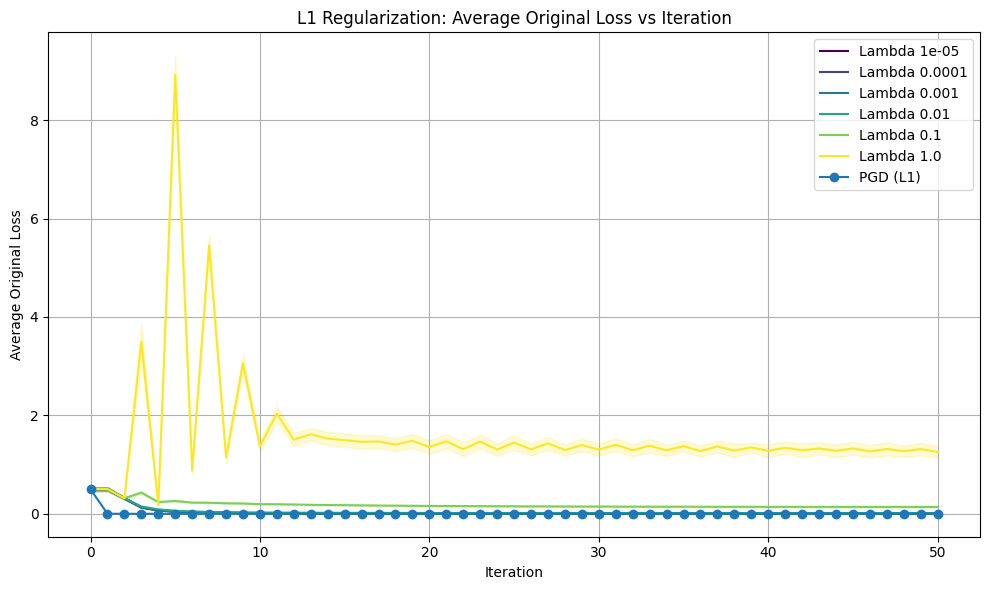

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define iterations and color map
iterations = range(max_iter + 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_list)))


# Plot for L1 regularization
plt.figure(figsize=(10, 6))
for i, lam in enumerate(lambda_list):
    avg_loss_hist = l1_results[lam]['avg']
    var_loss_hist = l1_results[lam]['var']
    plt.plot(iterations, avg_loss_hist, label=f"Lambda {lam}", color=colors[i])
    plt.fill_between(iterations, avg_loss_hist - np.sqrt(var_loss_hist),
                     avg_loss_hist + np.sqrt(var_loss_hist), color=colors[i], alpha=0.2)

plt.plot(iterations, loss_pgd_l1, label='PGD (L1)', linestyle='-', marker='o')
plt.title("L1 Regularization: Average Original Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Original Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


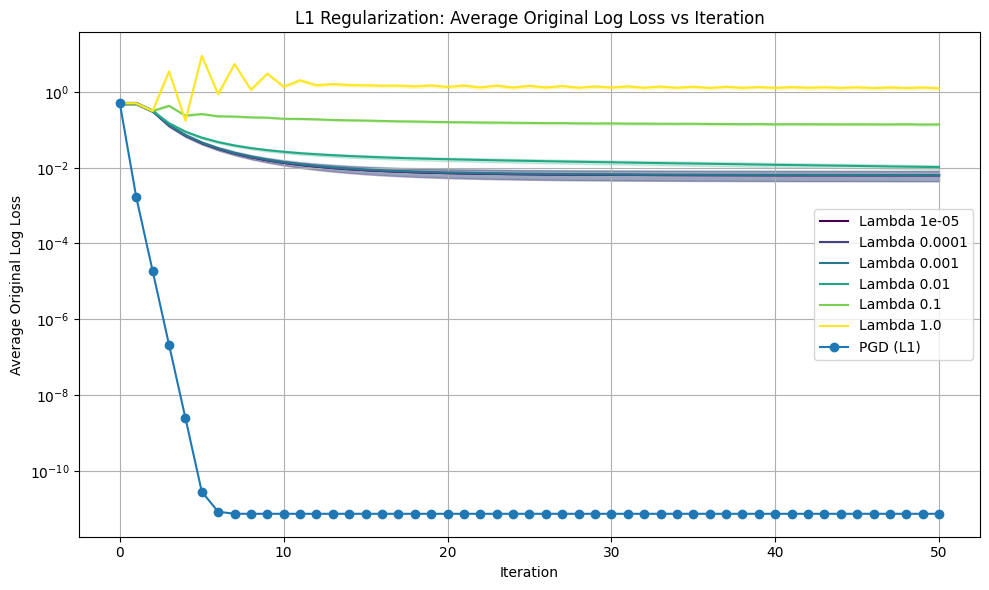

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Define iterations and color map
iterations = range(max_iter + 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_list)))


# Plot for L1 regularization
plt.figure(figsize=(10, 6))
for i, lam in enumerate(lambda_list):
    avg_loss_hist = l1_results[lam]['avg']
    var_loss_hist = l1_results[lam]['var']
    plt.plot(iterations, avg_loss_hist, label=f"Lambda {lam}", color=colors[i])
    plt.fill_between(iterations, avg_loss_hist - np.sqrt(var_loss_hist),
                     avg_loss_hist + np.sqrt(var_loss_hist), color=colors[i], alpha=0.2)

plt.plot(iterations, loss_pgd_l1, label='PGD (L1)', linestyle='-', marker='o')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

plt.title("L1 Regularization: Average Original Log Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Original Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




As for the L1 regularization, when the larger lambda you have, the larger change to the original loss function you have, and therefore you may converge to a non-optimal solution.

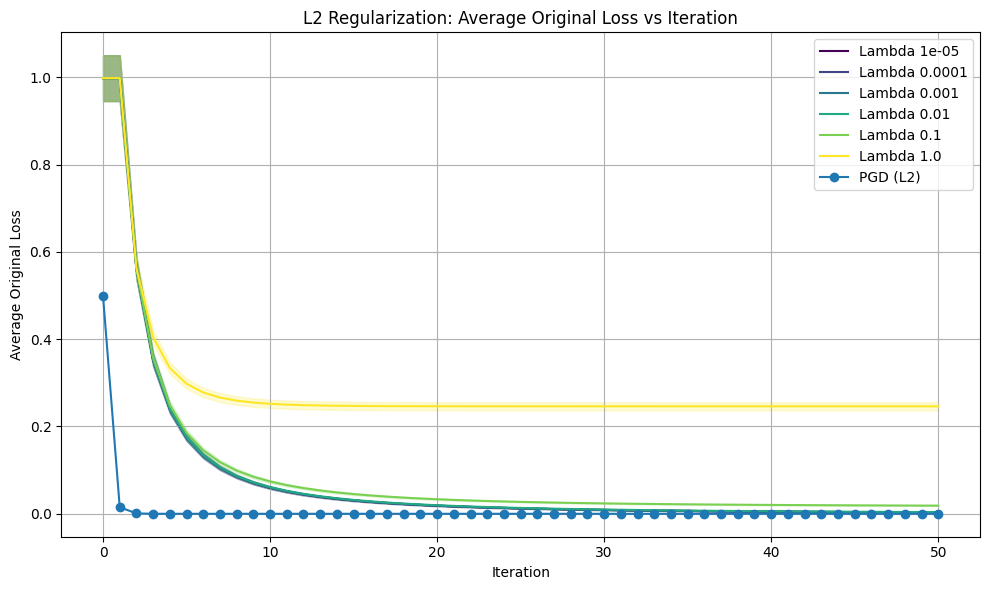

In [45]:
# Plot for L2 regularization
plt.figure(figsize=(10, 6))
for i, lam in enumerate(lambda_list):
    avg_loss_hist = l2_results[lam]['avg']
    var_loss_hist = l2_results[lam]['var']
    plt.plot(iterations, avg_loss_hist, label=f"Lambda {lam}", color=colors[i])
    plt.fill_between(iterations, avg_loss_hist - np.sqrt(var_loss_hist),
                     avg_loss_hist + np.sqrt(var_loss_hist), color=colors[i], alpha=0.2)
plt.plot(iterations, loss_pgd_l2, label='PGD (L2)', linestyle='-', marker='o')
plt.title("L2 Regularization: Average Original Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Original Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

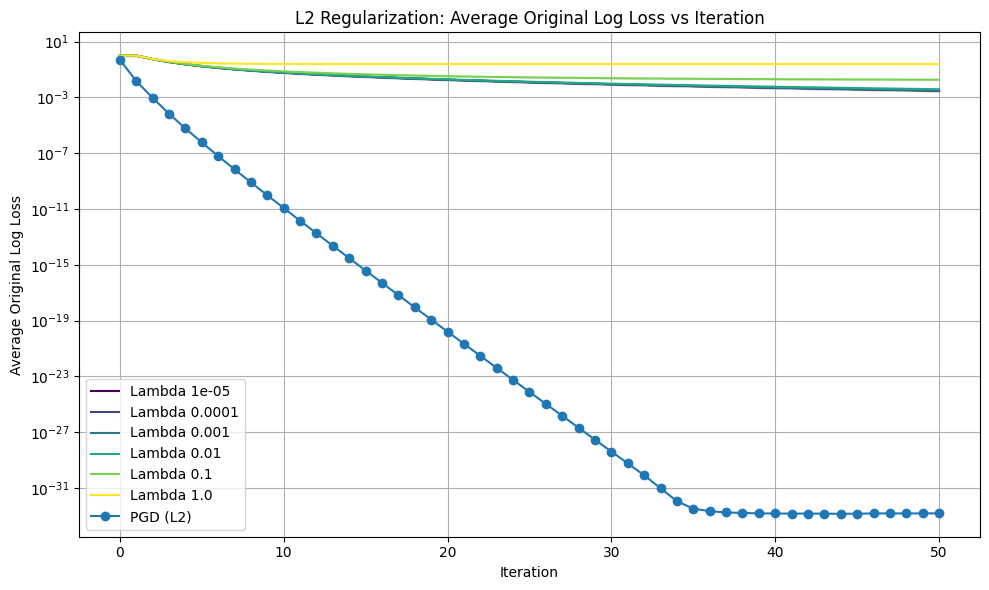

In [44]:
# Plot for L2 regularization
plt.figure(figsize=(10, 6))
for i, lam in enumerate(lambda_list):
    avg_loss_hist = l2_results[lam]['avg']
    var_loss_hist = l2_results[lam]['var']
    plt.plot(iterations, avg_loss_hist, label=f"Lambda {lam}", color=colors[i])
    plt.fill_between(iterations, avg_loss_hist - np.sqrt(var_loss_hist),
                     avg_loss_hist + np.sqrt(var_loss_hist), color=colors[i], alpha=0.2)
plt.plot(iterations, loss_pgd_l2, label='PGD (L2)', linestyle='-', marker='o')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

plt.title("L2 Regularization: Average Original Log Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Original Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Even though we have shown that the l2 regularization does introduce a feasiblity to the constraint optimization task, since the extra regularization term, we can't ensure the optimality.

In the reality, we are not using projected gradient descent for regularization task might mainly because compare to the loss on the objective, we prefer the cheap calculation. However, in some specific task, when we do want to ensure the feasibility of the constraint optimization task, for example when we want to apply a Trust Region Policy Optimization, projected gradient descent can ensure the feasibility while not change the optimization problem. The only problem is to find a good may to approximate the projection to the feasible region.